In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
%matplotlib inline
import os

In [2]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder("input/data/", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

In [3]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

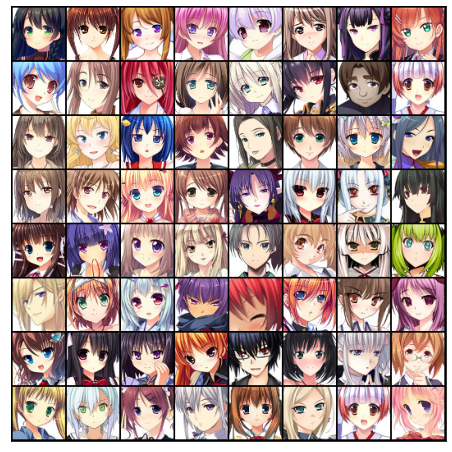

In [5]:
show_batch(train_dl)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [7]:
device = get_default_device()
device

device(type='cpu')

In [8]:
train_dl = DeviceDataLoader(train_dl, device)

In [9]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [10]:
discriminator = to_device(discriminator, device)

In [11]:
latent_size = 128

In [12]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


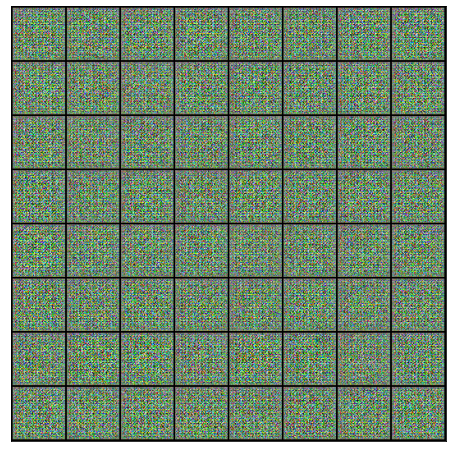

In [13]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [14]:
generator = to_device(generator, device)

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [17]:
def show_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [18]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


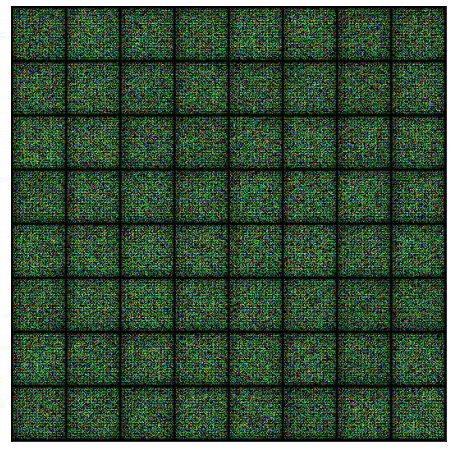

In [19]:
show_samples(0, fixed_latent)

In [20]:
def fit(epochs, lr, start_idx=1, show=False):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    return losses_g, losses_d, real_scores, fake_scores

In [21]:
lr = 0.0002
epochs = 50

In [22]:
history = fit(epochs, lr)

  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.9074, loss_d: 0.7505, real_score: 0.5879, fake_score: 0.0917


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 5.5418, loss_d: 1.0561, real_score: 0.9126, fake_score: 0.5389


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 3.4123, loss_d: 0.5566, real_score: 0.6888, fake_score: 0.1015


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.0635, loss_d: 0.6563, real_score: 0.6284, fake_score: 0.1157


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 2.6027, loss_d: 0.9723, real_score: 0.5028, fake_score: 0.0938


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 3.3508, loss_d: 0.2293, real_score: 0.8886, fake_score: 0.0920


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 7.8604, loss_d: 1.3105, real_score: 0.9116, fake_score: 0.6711


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.6537, loss_d: 0.5775, real_score: 0.7187, fake_score: 0.1598


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 5.2283, loss_d: 2.7554, real_score: 0.1282, fake_score: 0.0003


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.0549, loss_d: 0.5373, real_score: 0.7946, fake_score: 0.2245


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 7.3447, loss_d: 0.4946, real_score: 0.9384, fake_score: 0.3110


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.3085, loss_d: 0.3604, real_score: 0.8286, fake_score: 0.1195


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 6.4526, loss_d: 0.4863, real_score: 0.8718, fake_score: 0.2641


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.1993, loss_d: 0.4173, real_score: 0.9079, fake_score: 0.2435


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.0251, loss_d: 0.3361, real_score: 0.8532, fake_score: 0.1389


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.7118, loss_d: 0.6566, real_score: 0.5932, fake_score: 0.0035


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 7.8803, loss_d: 0.3429, real_score: 0.7534, fake_score: 0.0036


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 8.8169, loss_d: 0.7528, real_score: 0.9113, fake_score: 0.4284


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 8.5375, loss_d: 0.6562, real_score: 0.9871, fake_score: 0.4093


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.6487, loss_d: 0.5622, real_score: 0.6799, fake_score: 0.0422


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.3378, loss_d: 0.3081, real_score: 0.8887, fake_score: 0.1435


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 6.8849, loss_d: 0.4502, real_score: 0.7107, fake_score: 0.0028


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 5.4934, loss_d: 0.1778, real_score: 0.9226, fake_score: 0.0766


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 6.1255, loss_d: 0.3794, real_score: 0.9569, fake_score: 0.2420


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.1746, loss_d: 0.3020, real_score: 0.9043, fake_score: 0.1544


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.3032, loss_d: 0.3053, real_score: 0.8734, fake_score: 0.1309


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 2.9970, loss_d: 0.3443, real_score: 0.8408, fake_score: 0.1177


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.8838, loss_d: 0.6948, real_score: 0.9618, fake_score: 0.4241


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.1105, loss_d: 0.2063, real_score: 0.9499, fake_score: 0.1231


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 9.8366, loss_d: 0.5885, real_score: 0.9667, fake_score: 0.3626


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.6185, loss_d: 0.2384, real_score: 0.9055, fake_score: 0.1132


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 2.6082, loss_d: 0.4254, real_score: 0.7199, fake_score: 0.0097


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.1094, loss_d: 0.1438, real_score: 0.9698, fake_score: 0.0969


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.5751, loss_d: 0.1917, real_score: 0.9407, fake_score: 0.1074


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 8.3704, loss_d: 0.6105, real_score: 0.9846, fake_score: 0.3866


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.3556, loss_d: 0.2699, real_score: 0.8027, fake_score: 0.0147


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.4911, loss_d: 0.2139, real_score: 0.9225, fake_score: 0.1118


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.4328, loss_d: 0.2109, real_score: 0.8800, fake_score: 0.0566


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 6.4297, loss_d: 0.1955, real_score: 0.9743, fake_score: 0.1427


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.9538, loss_d: 0.2058, real_score: 0.9783, fake_score: 0.1496


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.8649, loss_d: 0.3856, real_score: 0.9775, fake_score: 0.2443


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.1680, loss_d: 0.1834, real_score: 0.9204, fake_score: 0.0820


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.3791, loss_d: 1.3331, real_score: 0.3645, fake_score: 0.0001


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.5947, loss_d: 0.1769, real_score: 0.9438, fake_score: 0.0994


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.5095, loss_d: 1.0074, real_score: 0.5246, fake_score: 0.0069


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.7367, loss_d: 0.1416, real_score: 0.9687, fake_score: 0.0938


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.1427, loss_d: 0.1601, real_score: 0.8927, fake_score: 0.0343


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.2923, loss_d: 0.2620, real_score: 0.9880, fake_score: 0.2002


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.3066, loss_d: 0.1634, real_score: 0.9740, fake_score: 0.1152


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.2543, loss_d: 0.1299, real_score: 0.9476, fake_score: 0.0656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


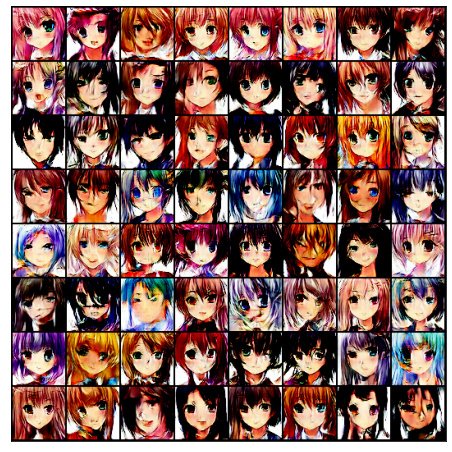

In [23]:
show_samples(0, fixed_latent)

In [24]:
losses_g, losses_d, real_scores, fake_scores = history

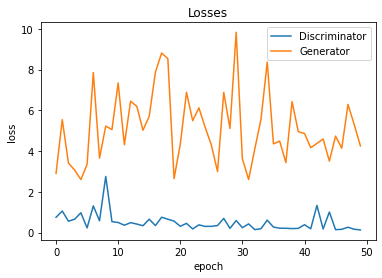

In [25]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

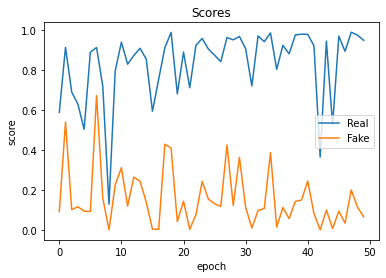

In [26]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');